# Using object oriented API

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import hillmaker as hm

## An OO version of hillmaker

Recently, an object oriented API was added to hillmaker to allow analysts to have finer control over the analysis process. Some of the features and architectural details include:

- a `Scenario` class which has methods for running hillmaker (`make_hills()`) and for retrieving plots and dataframes from the results dictionary (`get_plot()`, `get_summary_df()`, and `get_bydatetime_df()`). 
- the plots and dataframes produced by `make_hills()` are stored in a dictionary called `hills` that is an attribute of the `Scenario` class.
- the methods of the `Scenario` class are just wrappers that call module level functions of the same name that do the actual work. By doing this, we kept the legacy function interface described in {doc}`using_make_hills`.
- the `Scenario` class is actually a [pydantic model](https://docs.pydantic.dev/latest/) which handles input validation.

## The example scenario

Again, we'll use the Short Stay Unit data for this tutorial.

In [3]:
ssu_stopdata = './data/ssu_2024.csv'
ssu_stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
ssu_stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


## The `Scenario` class

The `Scenario` class is a [pydantic model](https://docs.pydantic.dev/latest/). It handles a bunch of type constraints, validation, and default values. 

We can create scenarios a few different ways.

- instantiate an instance of `Scenario` by passing in keyword arguments,
- there's a `create_scenario` function that can take any or all of a dictionary, a TOML path or keyword argurments and returns a `Scenario` object (precedence is in the reverse order - kwargs get the final say).

### Create a new scenario with keyword arguments

You can create an instance of `Scenario` by passing in keyword arguments.

Here are a collection of inputs that we'll use to create a scenario. Notice we purposely set one of the input dates to a string and the other to a `Timestamp` just to show that the `pydantic` model can handle the automatic transformation for us to a `datetime`.

In [4]:
# Required inputs
scenario_name = 'ssu_oo_1'
stops_df = ssu_stops_df
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '2024-06-01'
end_date = pd.Timestamp('8/31/2024')

# Optional inputs
cat_field_name = 'PatType'
bin_size_minutes = 60

In [5]:
scenario_1 = hm.Scenario(scenario_name=scenario_name, 
                         data=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date,
                         end_analysis_dt=end_date,
                         cat_field=cat_field_name,
                         bin_size_minutes=bin_size_minutes)

In [6]:
print(scenario_1)

Required inputs
-------------------------
scenario_name = ssu_oo_1
data =
       PatID            InRoomTS           OutRoomTS PatType  LOS_hours
0          1 2024-01-01 07:44:00 2024-01-01 09:20:00     IVT   1.600000
1          2 2024-01-01 08:28:00 2024-01-01 11:13:00     IVT   2.750000
2          3 2024-01-01 11:44:00 2024-01-01 12:48:00     MYE   1.066667
3          4 2024-01-01 11:51:00 2024-01-01 21:10:00     CAT   9.316667
4          5 2024-01-01 12:10:00 2024-01-01 12:57:00     IVT   0.783333
...      ...                 ...                 ...     ...        ...
59872  59873 2024-09-30 19:31:00 2024-09-30 20:34:00     IVT   1.050000
59873  59874 2024-09-30 20:23:00 2024-09-30 22:22:00     IVT   1.983333
59874  59875 2024-09-30 21:00:00 2024-09-30 23:22:00     CAT   2.366667
59875  59876 2024-09-30 21:57:00 2024-10-01 01:58:00     IVT   4.016667
59876  59877 2024-09-30 22:45:00 2024-10-01 03:18:00     CAT   4.550000

[59877 rows x 5 columns]
in_field = InRoomTS
out_field = OutR

Now use the `make_hills` method to run hillmaker.

In [7]:
scenario_1.make_hills()

By default, only weekly plots are created - `make_all_dow_plots` defaults to False and `make_all_week_plots` defaults to True.

In [8]:
scenario_1.hills.keys()

dict_keys(['bydatetime', 'summaries', 'los_summary', 'settings', 'plots', 'runtime'])

In [9]:
summary_df = scenario_1.get_summary_df(by_category=False)
summary_df

,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,0,Mon,0,00:00,13.0,1.001282,0.0,3.000000,0.923396,0.256104,0.852660,0.922214,0.789389,0.158285,0.250000,1.000000,1.450000,2.400000,2.880000
1,0,Mon,1,01:00,13.0,0.980769,0.0,2.600000,0.756724,0.209878,0.572632,0.771562,0.582793,0.606338,0.750000,1.000000,1.133333,2.240000,2.528000
2,0,Mon,2,02:00,13.0,0.734615,0.0,1.866667,0.628802,0.174398,0.395392,0.855961,0.026817,-1.153303,0.000000,1.000000,1.000000,1.546667,1.802667
3,0,Mon,3,03:00,13.0,0.598718,0.0,1.733333,0.604093,0.167545,0.364929,1.008978,0.269351,-1.274639,0.000000,1.000000,1.000000,1.303333,1.647333
4,0,Mon,4,04:00,13.0,0.539744,0.0,2.000000,0.633536,0.175711,0.401368,1.173772,0.988444,0.557461,0.000000,0.300000,1.000000,1.400000,1.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,6,Sun,19,19:00,13.0,1.885897,0.0,5.400000,1.417367,0.393107,2.008928,0.751561,1.077564,2.303828,1.000000,2.000000,2.116667,3.970000,5.114000
164,6,Sun,20,20:00,13.0,1.603846,0.0,4.000000,1.100550,0.305238,1.211211,0.686194,0.580109,0.805758,1.000000,1.683333,2.016667,3.390000,3.878000
165,6,Sun,21,21:00,13.0,1.730769,0.0,4.466667,1.170803,0.324722,1.370780,0.676464,0.992959,1.212156,1.000000,1.266667,2.466667,3.586667,4.290667
166,6,Sun,22,22:00,13.0,1.352564,0.0,4.066667,1.117347,0.309896,1.248465,0.826096,1.309961,2.012192,1.000000,1.016667,1.666667,3.366667,3.926667


In [10]:
summary_df[summary_df['dow_name']=='Mon']

,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,0,Mon,0,00:00,13.0,1.001282,0.000000,3.000000,0.923396,0.256104,0.852660,0.922214,0.789389,0.158285,0.250000,1.000000,1.450000,2.400000,2.880000
1,0,Mon,1,01:00,13.0,0.980769,0.000000,2.600000,0.756724,0.209878,0.572632,0.771562,0.582793,0.606338,0.750000,1.000000,1.133333,2.240000,2.528000
2,0,Mon,2,02:00,13.0,0.734615,0.000000,1.866667,0.628802,0.174398,0.395392,0.855961,0.026817,-1.153303,0.000000,1.000000,1.000000,1.546667,1.802667
3,0,Mon,3,03:00,13.0,0.598718,0.000000,1.733333,0.604093,0.167545,0.364929,1.008978,0.269351,-1.274639,0.000000,1.000000,1.000000,1.303333,1.647333
4,0,Mon,4,04:00,13.0,0.539744,0.000000,2.000000,0.633536,0.175711,0.401368,1.173772,0.988444,0.557461,0.000000,0.300000,1.000000,1.400000,1.880000
5,0,Mon,5,05:00,13.0,1.738462,0.083333,4.016667,1.221895,0.338893,1.493027,0.702860,0.719157,-0.067127,0.750000,1.566667,2.183333,3.946667,4.002667
6,0,Mon,6,06:00,13.0,15.611538,12.933333,21.483333,2.253489,0.625005,5.078212,0.144348,1.536775,2.969572,14.400000,14.816667,17.083333,19.053333,20.997333
7,0,Mon,7,07:00,13.0,30.598718,23.833333,35.350000,3.758518,1.042425,14.126457,0.122833,-0.201338,-1.089779,28.100000,29.683333,33.650000,35.260000,35.332000
8,0,Mon,8,08:00,13.0,40.041026,28.866667,50.250000,6.065978,1.682400,36.796093,0.151494,-0.169844,-0.525927,35.300000,40.783333,44.816667,47.940000,49.788000
9,0,Mon,9,09:00,13.0,60.360256,46.600000,74.366667,7.248399,2.010344,52.539284,0.120086,0.227562,0.324710,56.900000,57.983333,64.916667,71.056667,73.704667


Plots can be retrieved with the `get_plot()` method.

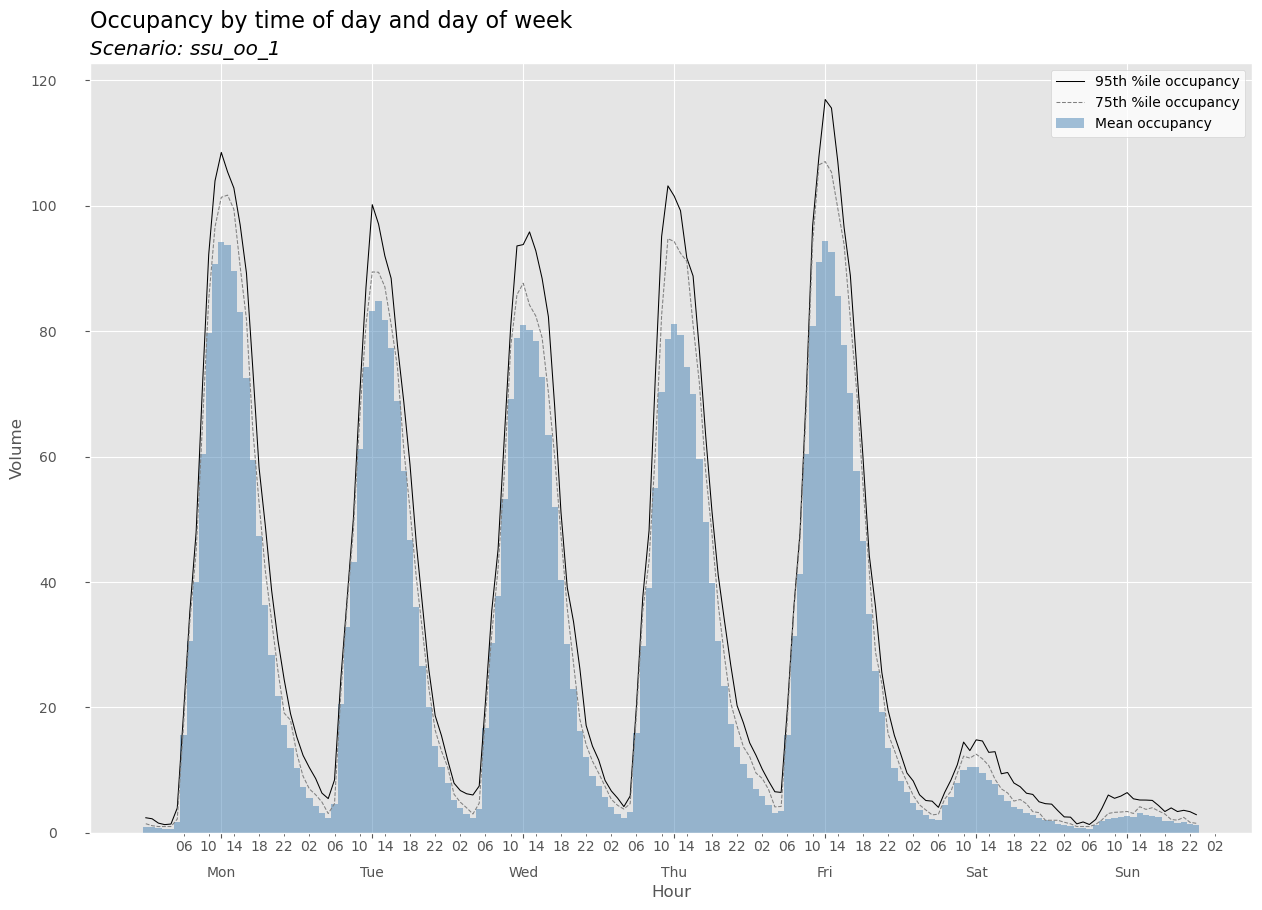

In [11]:
scenario_1.get_plot('occ')

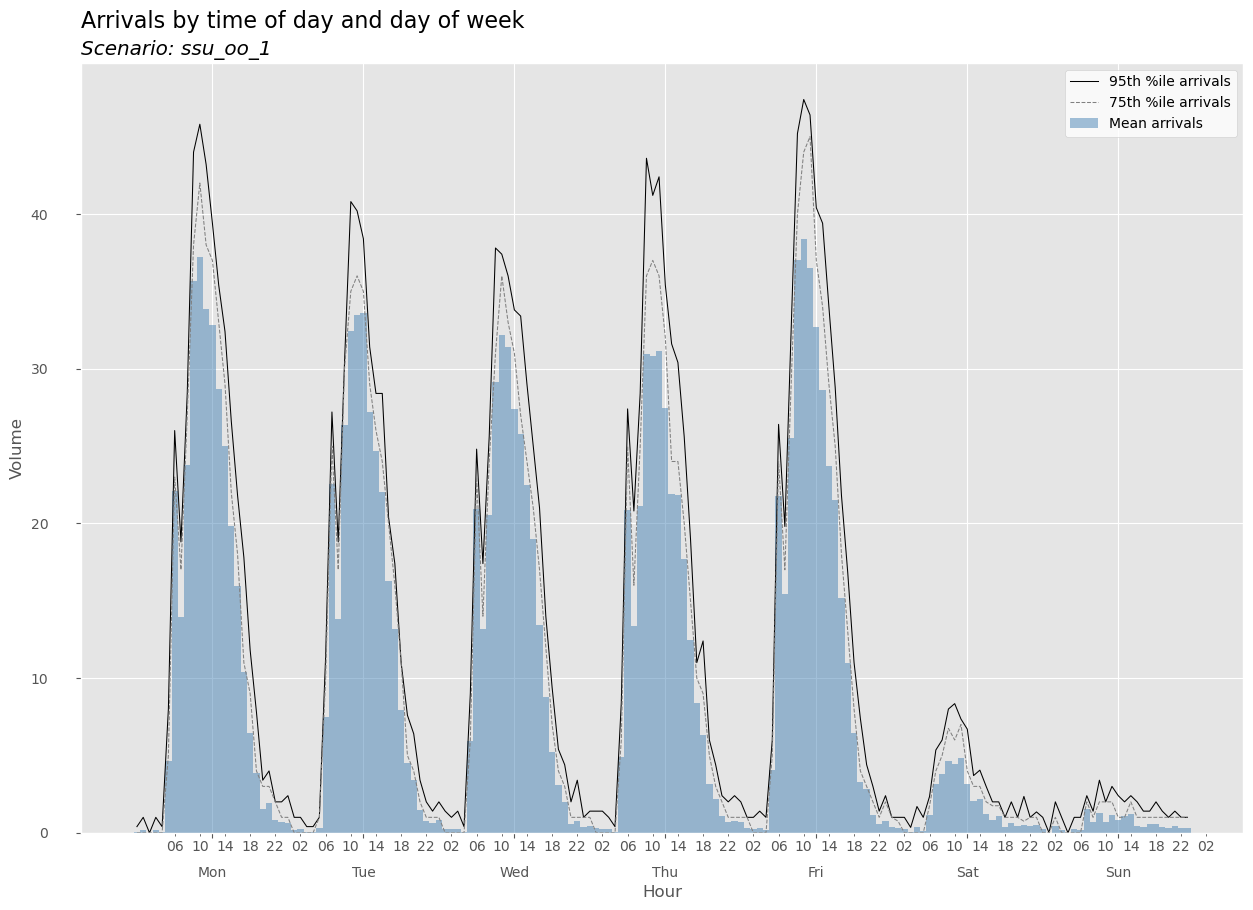

In [12]:
scenario_1.get_plot('arrivals')

If you prefer, you can also use the `compute_hills_stats()` method which will not create any plots. We'll create a new scenario that uses a smaller bins size.

In [13]:
scenario_1a = hm.Scenario(scenario_name='ssu_oo_1a', 
                         data=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date,
                         end_analysis_dt=end_date,
                         cat_field=cat_field_name,
                         bin_size_minutes=30)

In [14]:
scenario_1a.compute_hills_stats()

In [15]:
scenario_1a.hills.keys()

dict_keys(['bydatetime', 'summaries', 'los_summary', 'settings'])

Then later, if we decide to generate plots, we can.

In [16]:
help(scenario_1a.make_weekly_plot)

Help on method make_weekly_plot in module hillmaker.scenario:

make_weekly_plot(metric: str = 'occupancy', **kwargs) method of hillmaker.scenario.Scenario instance



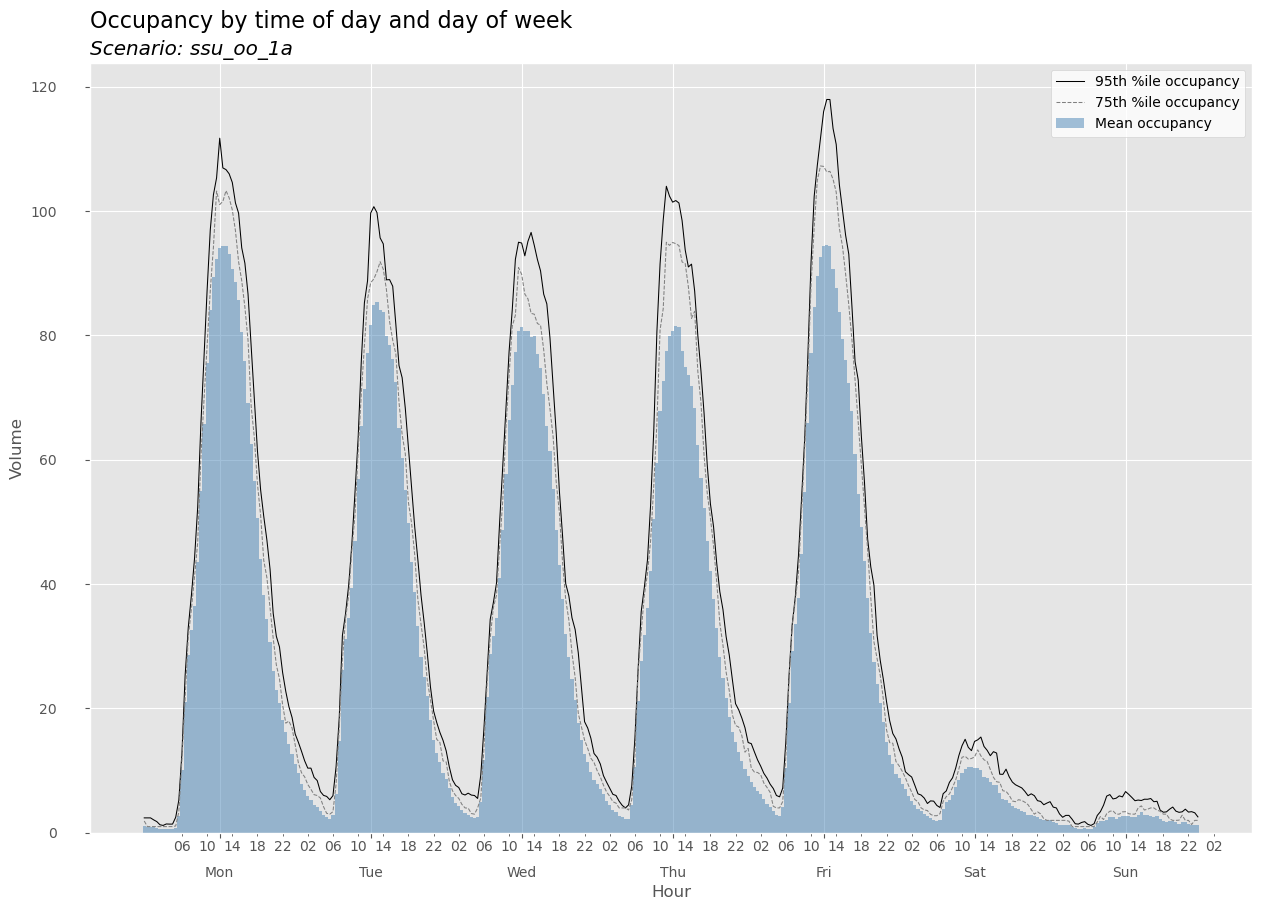

In [17]:
scenario_1a.make_weekly_plot()

If we provide `plot_export_path`, the plot will get exported as a PNG file.

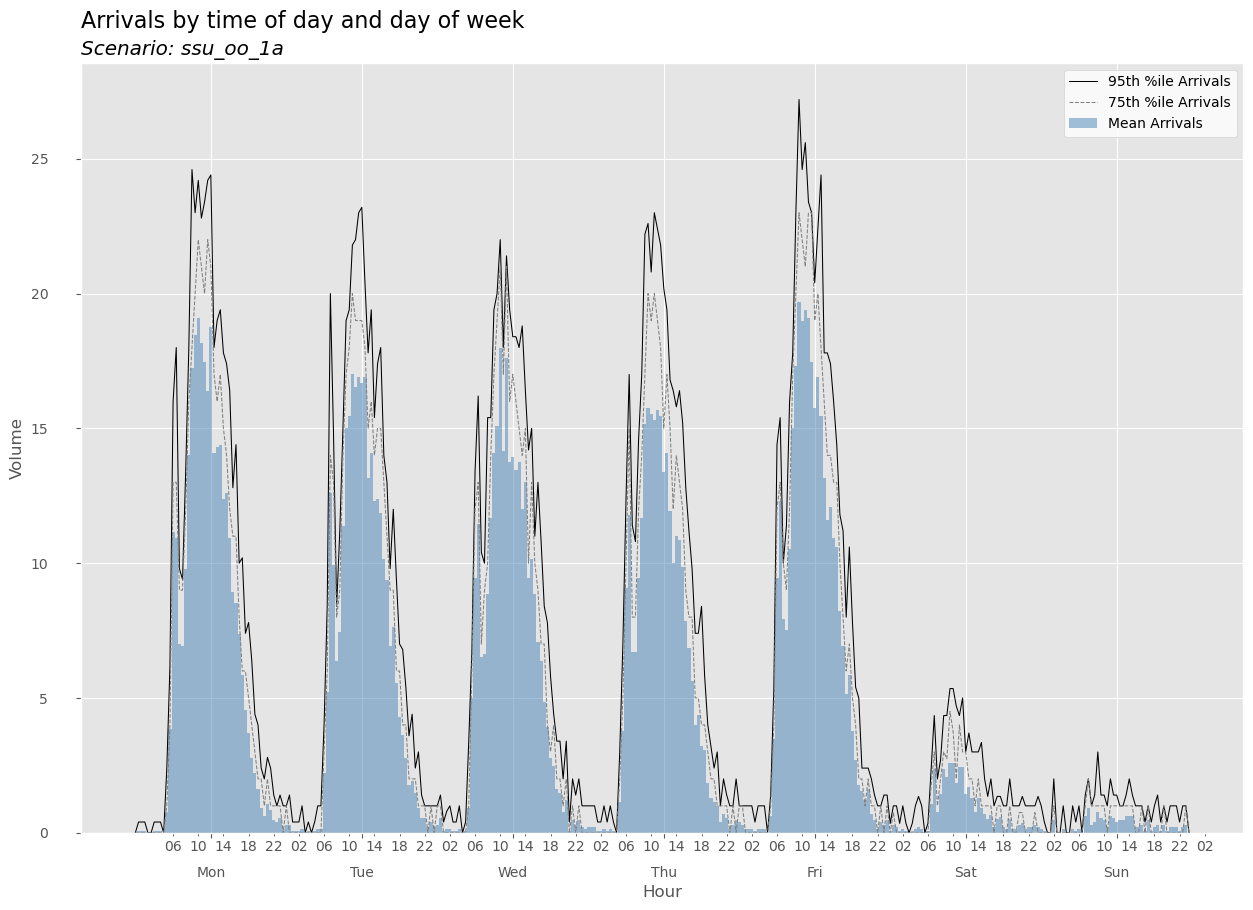

In [18]:
arrivals_plot = scenario_1a.make_weekly_plot(metric='Arrivals', plot_export_path='./output/')
arrivals_plot

You can use any of the plot related input parameters to style the plot.

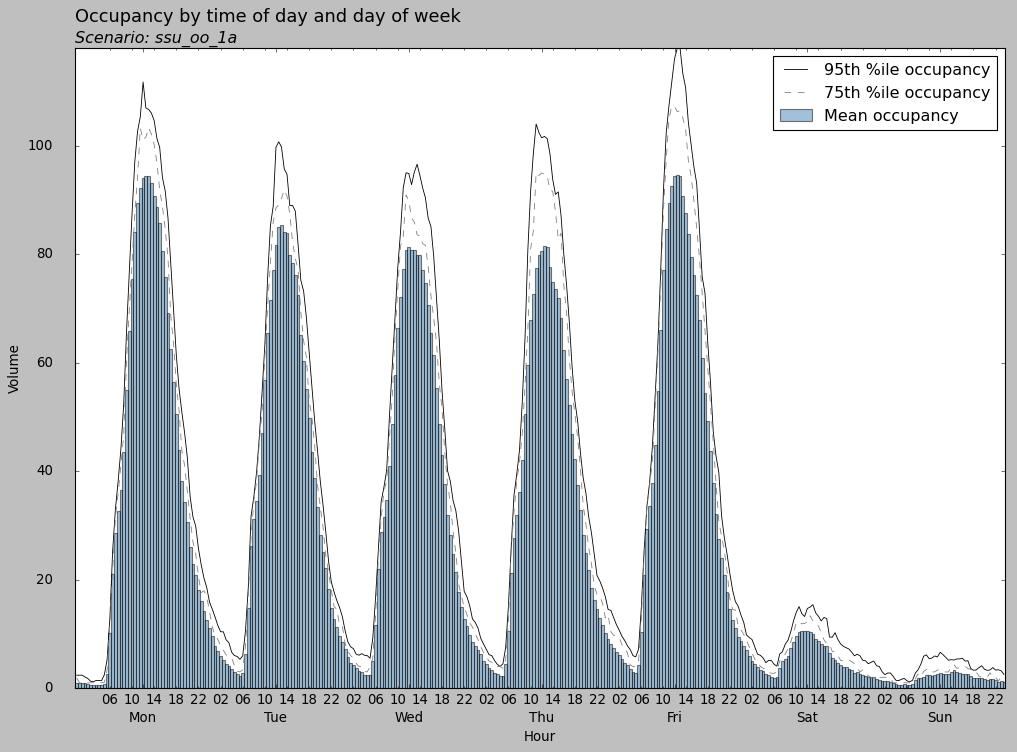

In [19]:
scenario_1a.make_weekly_plot(plot_style='classic')

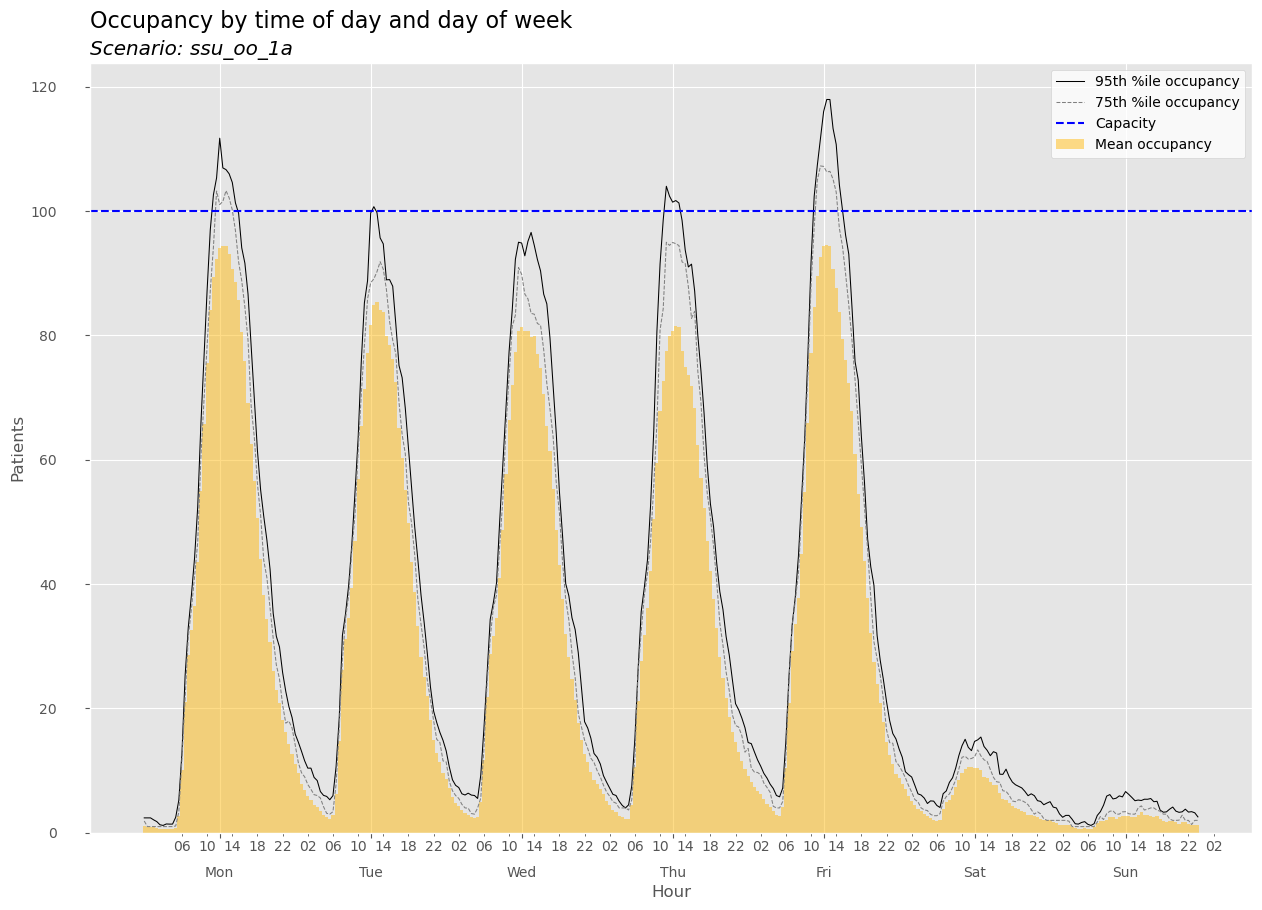

In [20]:
scenario_1a.make_weekly_plot(cap=100, cap_color='blue', bar_color_mean='#ffbb11',
                            ylabel='Patients')

## Create scenario from a config file

To use a TOML configuration file to create a scenario, we can use the `create_scenario` function.

Here's what an example config file might look like. The `scenario_name` and `bin_size_minutes` have been changed from the first scenario in this notebook.

```
[scenario_data]
scenario_name = "ss_oo_2"
data = "./data/ssu_2024.csv"

[fields]
in_field = "InRoomTS"
out_field = "OutRoomTS"
# Just remove the following line if no category field
cat_field = "PatType"

[analysis_dates]
start_analysis_dt = 2024-01-02
end_analysis_dt = 2024-03-30

[settings]
bin_size_minutes = 120
verbosity = 1
csv_export_path = './output'
plot_export_path = './output'

# Add any additional arguments here
# Strings should be surrounded in double quotes
# Floats and ints are specified in the normal way as values
# Dates are specified as shown above

# For arguments that take lists, the entries look
# just like Python lists and following the other rules above

# cats_to_exclude = ["IVT", "OTH"]
# percentiles = [0.5, 0.8, 0.9]

# For arguments that take dictionaries, do this:
# main_title_properties = {loc = 'left', fontsize = 16}
# subtitle_properties = {loc = 'left', style = 'italic'}
# legend_properties = {loc = 'best', frameon = true, facecolor = 'w'}
```

The sections headings, `[scenario_data]`, `[fields]`, and `[analysis_dates]` aren't actually necessary. You could actually put all input parameters within the `[settings]` section. Including the other headings is just an organizational aid.

```{warning}
You MUST include at least the `[settings]` section header.
```

In [21]:
help(hm.create_scenario)

Help on function create_scenario in module hillmaker.scenario:

create_scenario(params_dict: Optional[Dict] = None, config_path: Union[str, pathlib.Path, NoneType] = None, **kwargs)
    Function to create a `Scenario` from a dict, a TOML config file, and/or keyword args



From the `help()` we see that there are three ways to pass input parameters into the `create_scenario()` function. If you specify a `config_path`, any inputs set via the config file will override values previously set with the `params_dict` dictionary. Similarly, any inputs set via `**kwargs` will override any set via `params_dict` or `config_path`.

In [22]:
scenario_2 = hm.create_scenario(config_path='./input/ssu_oo_2.toml')

In [23]:
print(scenario_2)

Required inputs
-------------------------
scenario_name = ss_oo_2
data =
       PatID            InRoomTS           OutRoomTS PatType  LOS_hours
0          1 2024-01-01 07:44:00 2024-01-01 09:20:00     IVT   1.600000
1          2 2024-01-01 08:28:00 2024-01-01 11:13:00     IVT   2.750000
2          3 2024-01-01 11:44:00 2024-01-01 12:48:00     MYE   1.066667
3          4 2024-01-01 11:51:00 2024-01-01 21:10:00     CAT   9.316667
4          5 2024-01-01 12:10:00 2024-01-01 12:57:00     IVT   0.783333
...      ...                 ...                 ...     ...        ...
59872  59873 2024-09-30 19:31:00 2024-09-30 20:34:00     IVT   1.050000
59873  59874 2024-09-30 20:23:00 2024-09-30 22:22:00     IVT   1.983333
59874  59875 2024-09-30 21:00:00 2024-09-30 23:22:00     CAT   2.366667
59875  59876 2024-09-30 21:57:00 2024-10-01 01:58:00     IVT   4.016667
59876  59877 2024-09-30 22:45:00 2024-10-01 03:18:00     CAT   4.550000

[59877 rows x 5 columns]
in_field = InRoomTS
out_field = OutRo

## Create a new scenario using `create_scenario()` and a dictionary

The `create_scenario` function also can take, as input, a dictionary of input arguments. Notice in the example below that strings are used for the dates but they just as well could be `datetime` or `TimeStamp` objects - anything that can be converted to a pandas `TimeStamp` is allowed. I've only included the required parameters and two optional parameters - `cat_field` and `bin_size_mins`.

```
ssu_oo_3_dict = {
    'scenario_name': 'ssu_oo_3',
    'stops_df': ssu_stops_df,
    'in_field': 'InRoomTS',
    'out_field': 'OutRoomTS',
    'start_analysis_dt': '2024-01-01',
    'end_analysis_dt': '2024-09-30',
    'cat_field': 'PatType',
    'bin_size_minutes': 60
}
```

In [24]:
ssu_oo_3_dict = {
    'scenario_name': 'ssu_oo_3',
    'data': ssu_stops_df,
    'in_field': 'InRoomTS',
    'out_field': 'OutRoomTS',
    'start_analysis_dt': '2024-01-01',
    'end_analysis_dt': '2024-09-30',
    'cat_field': 'PatType',
    'bin_size_minutes': 60
}

ssu_oo_3 = hm.create_scenario(params_dict=ssu_oo_3_dict)
print(ssu_oo_3)


Required inputs
-------------------------
scenario_name = ssu_oo_3
data =
       PatID            InRoomTS           OutRoomTS PatType  LOS_hours
0          1 2024-01-01 07:44:00 2024-01-01 09:20:00     IVT   1.600000
1          2 2024-01-01 08:28:00 2024-01-01 11:13:00     IVT   2.750000
2          3 2024-01-01 11:44:00 2024-01-01 12:48:00     MYE   1.066667
3          4 2024-01-01 11:51:00 2024-01-01 21:10:00     CAT   9.316667
4          5 2024-01-01 12:10:00 2024-01-01 12:57:00     IVT   0.783333
...      ...                 ...                 ...     ...        ...
59872  59873 2024-09-30 19:31:00 2024-09-30 20:34:00     IVT   1.050000
59873  59874 2024-09-30 20:23:00 2024-09-30 22:22:00     IVT   1.983333
59874  59875 2024-09-30 21:00:00 2024-09-30 23:22:00     CAT   2.366667
59875  59876 2024-09-30 21:57:00 2024-10-01 01:58:00     IVT   4.016667
59876  59877 2024-09-30 22:45:00 2024-10-01 03:18:00     CAT   4.550000

[59877 rows x 5 columns]
in_field = InRoomTS
out_field = OutR

With `create_scenario`, you can also include keyword arguments that will take precedence over those specified in either a TOML file or a dictionary. 

In [25]:
ssu_oo_3 = hm.create_scenario(params_dict=ssu_oo_3_dict, 
                              export_summaries_csv=True, csv_export_path='./output',
                              bin_size_minutes=30)

print(ssu_oo_3.export_summaries_csv)
print(ssu_oo_3.bin_size_minutes)

True
30


Now let's generate hills by using the `make_hills` method of one of the scenario instances.

In [26]:
ssu_oo_3.make_hills()

We can use the `get_summary_df()` method to retrieve summary dataframes.

In [27]:
help(ssu_oo_3.get_summary_df)

Help on method get_summary_df in module hillmaker.scenario:

get_summary_df(flow_metric: str = 'occupancy', by_category: bool = True, stationary: bool = False) method of hillmaker.scenario.Scenario instance
    Get summary dataframe
    
    Parameters
    ----------
    flow_metric : str
        Either of 'arrivals', 'departures', 'occupancy' ('a', 'd', and 'o' are sufficient).
        Default='occupancy'
    by_category : bool
        Default=True corresponds to category specific statistics. A value of False gives overall statistics.
    stationary : bool
        Default=False corresponds to the standard nonstationary statistics (i.e. by TOD and DOW)
    
    Returns
    -------
    DataFrame



In [28]:
ssu_oo_3.get_summary_df()

,PatType,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,ART,0,Mon,0,00:00,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ART,0,Mon,1,00:30,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ART,0,Mon,2,01:00,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ART,0,Mon,3,01:30,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ART,0,Mon,4,02:00,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,OTH,6,Sun,43,21:30,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,OTH,6,Sun,44,22:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,OTH,6,Sun,45,22:30,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,OTH,6,Sun,46,23:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
